![Logo TUBAF](https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png)

Exercise material of the MSc-level course **Soil Dynamics**.
Held at Technische Universität Bergakademie Freiberg.

Comments to:

*Prof. Dr. Thomas Nagel  
Chair of Soil Mechanics and Foundation Engineering  
Geotechnical Institute  
Technische Universität Bergakademie Freiberg.*

https://tu-freiberg.de/en/soilmechanics


# Einmassenschwinger, Frequenzanalyse

![oscillator1dof.png](https://github.com/nagelt/soil_dynamics/raw/master/Images/oscillator1dof.png)

## Hilfsfunktionen

Module laden

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal.windows import hann   

Eingeschwungenen Zustand (partikuläre Lösung) berechnen, inklusive Vergrößerungsfunktion und Phasendifferenz

In [2]:
def steady_state_solution(omega, omega_n, D, a_c, a_s):
    beta = omega/omega_n
    if beta==1 and D==0:   
        # there are no steady-state terms, linear increase with time needs to be added manually
        V = 0.0 
        psi = 0.0
        u_c = 0.0
        u_s = 0.0
    else:        
        V2 = 1.0/( (1-beta**2)**2 + (2*beta*D)**2 )
        V = np.sqrt(V2)
        psi = np.arctan2(2*D*beta, 1-beta**2)
        u_c = V2*( (1-beta**2)*a_c - 2*D*beta*a_s )
        u_s = V2*( (1-beta**2)*a_s + 2*D*beta*a_c )
    return [u_c, u_s, V, psi]

Anpassen der Gesamtlösung an die Anfangsbedingungen

In [3]:
def transient_solution(t_0, u_0, v_0):
    # requires existence of uh(t), vh(t), up(t), vp(t)
    uh_c1 = uh_1(t_0)
    uh_c2 = uh_2(t_0)
    vh_c1 = vh_1(t_0)
    vh_c2 = vh_2(t_0)
    up_0 = up(t_0)
    vp_0 = vp(t_0)
    # LES M*x=b
    M = np.array([[uh_c1, uh_c2], [vh_c1, vh_c2]])
    b = np.array([u_0-up_0, v_0-vp_0])
    x = np.linalg.solve(M, b)
    C_1 = x[0]
    C_2 = x[1]
    return [C_1, C_2]

## Simulation 

Parameterdefinition

In [4]:
m = 3.0   # kg
k = 10.0   # N/m
c = 1.0   # Ns/m   
t_0 = 0.0   # s
u_0 = 0.0   # m
v_0 = 0.0   # m/s
# excitation (discrete spectrum)
T_a =  9.0  # s
A = [0.0, 0.0, 0.2,-0.2] # m
B = [0.0, 1.0, 0.0, 0.4] # m, note B_0 is irrelevant, since sin(0)=0

omega = 2*np.pi/T_a
omega_n = np.sqrt(k/m)
D = c/(2*np.sqrt(k*m))
N = len(A)
if N != len(B):
    print("Error: coefficient lists of different length")

Zusammengesetztes, harmonisches Anregungssignal

In [5]:
an = lambda n, t:  A[n]*np.cos(n*omega*t) + B[n]*np.sin(n*omega*t)   # Fourier series
a = lambda t: sum([an(nn, t) for nn in range(N)])   # superposition

Partikulärlösung

In [6]:
Uc = []   
Us = []   
undamped_resonance = False

for fn, (An, Bn) in enumerate(zip(A, B)):
    if fn*omega==omega_n and D==0:
        undamped_resonance = True
        rUs= 0.5*omega_n*An
        rUc= 0.5*omega_n*Bn
    [u_cn, u_sn, V, psi] = steady_state_solution(fn*omega, omega_n, D, An, Bn)
    Uc.append(u_cn)   
    Us.append(u_sn)

# steady-state solutions
upn = lambda n,t:   Uc[n]*np.cos(n*omega*t) + Us[n]*np.sin(n*omega*t)
vpn = lambda n,t: (-Uc[n]*np.sin(n*omega*t) + Us[n]*np.cos(n*omega*t))*n*omega   

# superposition of steady-state solutions and possibly resonant terms
if undamped_resonance:
    up = lambda t: sum([upn(nn, t) for nn in range(N)]) + t*(Us*np.sin(omega_n*t) + Uc*t*np.cos(omega_n*t))
    vp = lambda t: sum([vpn(nn, t) for nn in range(N)]) + Us*np.sin(omega_n*t) + Uc*t*np.cos(omega_n*t) + t*omega_n*(Us*np.cos(omega_n*t) - Uc*t*np.sin(omega_n*t))
else:
    up = lambda t: sum([upn(nn, t) for nn in range(N)])   
    vp = lambda t: sum([vpn(nn, t) for nn in range(N)])   

Lösung der homogenen Gleichung

In [7]:
if D < 1:
    omega_1 = omega_n*np.sqrt(1-D**2)
    delta = omega_n*D
    print("omega_1={:.3f} rad/s".format(omega_1), "   delta={:.3f} 1/s".format(delta))
    uh_1 = lambda t: np.exp(-delta*t)*np.cos(omega_1*t)
    uh_2 = lambda t: np.exp(-delta*t)*np.sin(omega_1*t)
    vh_1 = lambda t: np.exp(-delta*t)*( -delta*np.cos(omega_1*t) - omega_1*np.sin(omega_1*t) )
    vh_2 = lambda t: np.exp(-delta*t)*( -delta*np.sin(omega_1*t) + omega_1*np.cos(omega_1*t) )
elif D > 1:
    delta_1 = omega_n*(D - np.sqrt(D**2 - 1))
    delta_2 = omega_n*(D + np.sqrt(D**2 - 1))
    print("delta_1={:.3f} 1/s".format(delta_1), "   delta_2={:.3f} 1/s".format(delta_2) )
    uh_1 = lambda t: np.exp(-delta_1*t)
    uh_2 = lambda t: np.exp(-delta_2*t)
    vh_1 = lambda t: np.exp(-delta_1*t)*(-delta_1)
    vh_2 = lambda t: np.exp(-delta_2*t)*(-delta_2)
else:
    delta = omega_n*D
    print("delta={:.3f} 1/s".format(delta), "   (critical damping)")
    uh_1 = lambda t: np.exp(-delta*t)
    uh_2 = lambda t: t*np.exp(-delta*t)
    vh_1 = lambda t:-np.exp(-delta*t)*delta
    vh_2 = lambda t: np.exp(-delta*t) - t*np.exp(-delta*t)*delta

omega_1=1.818 rad/s    delta=0.167 1/s


Gesamtlösung für das erste Intervall (*Erdbeben*)

In [8]:
[C_1, C_2] = transient_solution(t_0, u_0, v_0)

uh = lambda t: C_1*uh_1(t) + C_2*uh_2(t) 
u = lambda t:  uh(t) + up(t) 
vh = lambda t: C_1*vh_1(t) + C_2*vh_2(t) 
v = lambda t:  vh(t) + vp(t) 

earthquake_repetitions = 3   # the longer observation interval, the finer frequency resolution (FFT)
t_T = t_0 + earthquake_repetitions*T_a
u_T = u(t_T) 
v_T = v(t_T)
t_sample_T = np.linspace(t_0, t_T , 500)   # discretization in time
a_sample_T  =  a(t_sample_T)
uh_sample_T = uh(t_sample_T)
up_sample_T = up(t_sample_T)
u_sample_T  =  u(t_sample_T)


Gesamtlösung für das zweite Intervall (*Nachwirkung*)

In [9]:
a  = lambda t: 0*t
up = lambda t: 0*t
vp = lambda t: 0*t

[C_1, C_2] = transient_solution(t_T, u_T, v_T)   # end of first intervall is begin of second
uh = lambda t: C_1*uh_1(t) + C_2*uh_2(t) 
u = lambda t:  uh(t) + up(t) 
vh = lambda t: C_1*vh_1(t) + C_2*vh_2(t) 
v = lambda t:  vh(t) + vp(t) 

aftermath_repetitions = 2
t_2T = t_T + aftermath_repetitions*T_a
t_sample_2T = np.linspace(t_T, t_2T , 500)   # discretization in time
a_sample_2T = a(t_sample_2T)
uh_sample_2T = uh(t_sample_2T)
up_sample_2T = up(t_sample_2T)
u_sample_2T = u(t_sample_2T)

Beide Intervalle zusammensetzen und grafisch darstellen

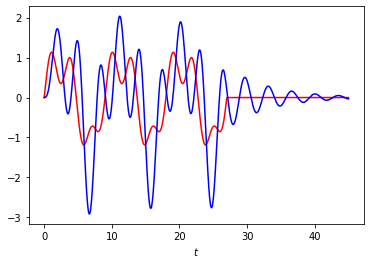

In [10]:
t_sample = np.concatenate((t_sample_T, t_sample_2T))
a_sample = np.concatenate((a_sample_T, a_sample_2T))
u_sample = np.concatenate((u_sample_T, u_sample_2T))

plt.figure(1)
plt.plot(t_sample, a_sample, 'r', t_sample, u_sample, 'b');
plt.xlabel("$t$");

## Anregungs- und Antwortspektrum berechnen

Das Anregungsspektrum (Eingang) ist gegeben, es wird zur Kontrolle nochmal berechnet und dem Antwortspektrum verglichen.

In [11]:
dt = t_sample[1] - t_sample[0] 
Na = len(t_sample_T)  
a_f = fft(a_sample_T)    
ta_f = fftfreq(Na, dt) 

Antwortspektrum (Ausgang)

In [12]:
Nu = len(t_sample_T) # 
w = hann(Nu)   # Hanning window
uw_f = fft(w*u_sample_T)     
tu_f = fftfreq(Nu, dt)[:Nu//2]

Grafische Darstellung (der unteren Frequenzen)

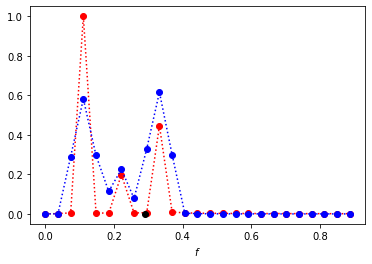

In [13]:
f0 = omega_n/(2*np.pi)   
plt.figure(2)
plt.plot(ta_f[:Na//20], (2/Na)*np.abs(a_f[:Na//20]), 'ro:', tu_f[:Nu//20], (2/Nu)*np.abs(uw_f[:Nu//20]), 'bo:', f0,0,'ko')
plt.xlabel("$f$");

Vergleichen Sie das Anregungsspektrum (rot) mit den gegebenen Koeffizienten ($A_n$, $B_n$) und der durch die Grundperiode $T_a$ gegebenen Frequenzen $f_n$ der Anregung.

Warum befinden sich die Maxima beider Spektren bei unterschiedlichen Frequenzen?
Hinweis: Der einzelne schwarze Punkt markiert die ungedämpfte Eigenfrequenz.

**Zusatzaufgabe:** komplexer Frequenzgang und Phasenspektrum